In [2]:
# These are the necessary additional libraries
!pip install scikit-learn
!pip install torch
!pip install matplotlib ipywidgets
!pip3 install wikipedia-api
!pip install pycausalimpact

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.4 MB/s eta 0:00:00


In [3]:
import os
import requests
import time
import json
from datetime import datetime
import pandas as pd
import numpy as np

# Libraries for the plots:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from IPython.display import display, clear_output
%matplotlib inline

# Libraries for the LSTM-based neural network model:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Libraries for statistical tests:
from causalimpact import CausalImpact
from scipy import stats
from scipy.stats import t

# Library for the wikipedia API
import wikipediaapi

import warnings
warnings.filterwarnings("ignore")

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# Navigate to target folder
%cd drive/MyDrive/data\ ADA\ project/

/content/drive/.shortcut-targets-by-id/1DMt9AR9J7QnOcoHE9gj-a0giuk_L8XuI/data ADA project


In [35]:
interventions = pd.read_csv('interventions.csv')
applemob = pd.read_csv('applemobilitytrends-2020-04-20.csv')
globalmob = pd.read_csv('Global_Mobility_Report.csv')

df_interventions = pd.read_csv("interventions.csv")
df_mobility = pd.read_csv("Global_Mobility_Report.csv")

interventions.set_index('lang', inplace=True)

with open('aggregated_timeseries.json', 'r') as f:
    d = json.load(f)

### 1. Entire Wikipedia

In [ ]:
df_wikiviews = fetch_wikiviews()
mehdi_p1(df_wikiviews, df_interventions)
mehdi_2(df_wikiviews, df_interventions)

In [ ]:
df_chess = fetch_chess()
interactive_chess(df_chess, df_interventions)

In [ ]:
df_boardgames, list_boardgames = fetch_boardgames()
interactive_boardgames(df_boardgames, list_boardgames, df_interventions)

In [ ]:
df_boardgames_en = extract_bg_en(df_boardgames)
interactive_boardgames_lang(df_boardgames, df_interventions)
show_standardized_boardgames_en(df_interventions, df_boardgames_en)

In [ ]:
model = train_evaluate_LSTM_model(pre_process_data(df_boardgames_en))
test_model(df_boardgames_en, df_interventions, model)

In [4]:
# Code for the language of the countries for the following study
country_code = ['en', 'fr', 'it', 'de', 'ja']

start_dt = '2017010100'
end_dt = '2023120100'

headers = {'User-Agent':'ADABot/0.0 (floydchow7@gmail.com)'}

In [10]:
# Returns the df_query for the given url
def return_wiki_fetched(url):
    try:
      r = requests.get(url, headers=headers)
      df_onequery = pd.DataFrame(r.json()['items'])
      time.sleep(0.5) # In case the IP address is blocked
      return df_onequery
    except:
      print('The {} page views are not found during these time'.format(country))

In [11]:
df_wikiviews = pd.DataFrame()

for country in country_code:
  # Retrieve page views for the entire wikipedia for a particular country:
  url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{country}.wikipedia/all-access/user/daily/{start_dt}/{end_dt}"
  df_wikiviews = pd.concat([df_wikiviews, return_wiki_fetched(url)])

# Additional retrieval for all languages to show the change of views during lockdown
url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/all-projects/all-access/user/daily/{start_dt}/{end_dt}"
df_wikiviews = pd.concat([df_wikiviews, return_wiki_fetched(url)])

In [12]:
# Data Wrangling:
df_wikiviews = df_wikiviews[['project', 'timestamp', 'views']].reset_index(drop=True)
df_wikiviews['timestamp'] = pd.to_datetime(df_wikiviews['timestamp'], format='%Y%m%d%H')
df_wikiviews['project'] = df_wikiviews['project'].str.replace(r'\..*', '', regex=True)
df_wikiviews = df_wikiviews.pivot_table(index = 'timestamp', columns = ['project'], values = 'views')

In [9]:
df_wikiviews.head()

project,all-projects,de,en,fr,it,ja
timestamp,,,,,,
2017-01-01,513890830,35721403,257199090,23526251,16906862,34656144
2017-01-02,584443014,37589936,289715316,27741015,19924081,38006354
2017-01-03,586396631,37645167,287019962,26070013,20117275,38913421
2017-01-04,575595049,37934985,278697244,26876275,19834792,39310106
2017-01-05,571147859,37514710,279026471,26073362,19081602,37994530


Here we separate the data of the pageviews for the entire project and plot bars for each month, the months that are impacted by the Covid-19 pandemic are shown in red.

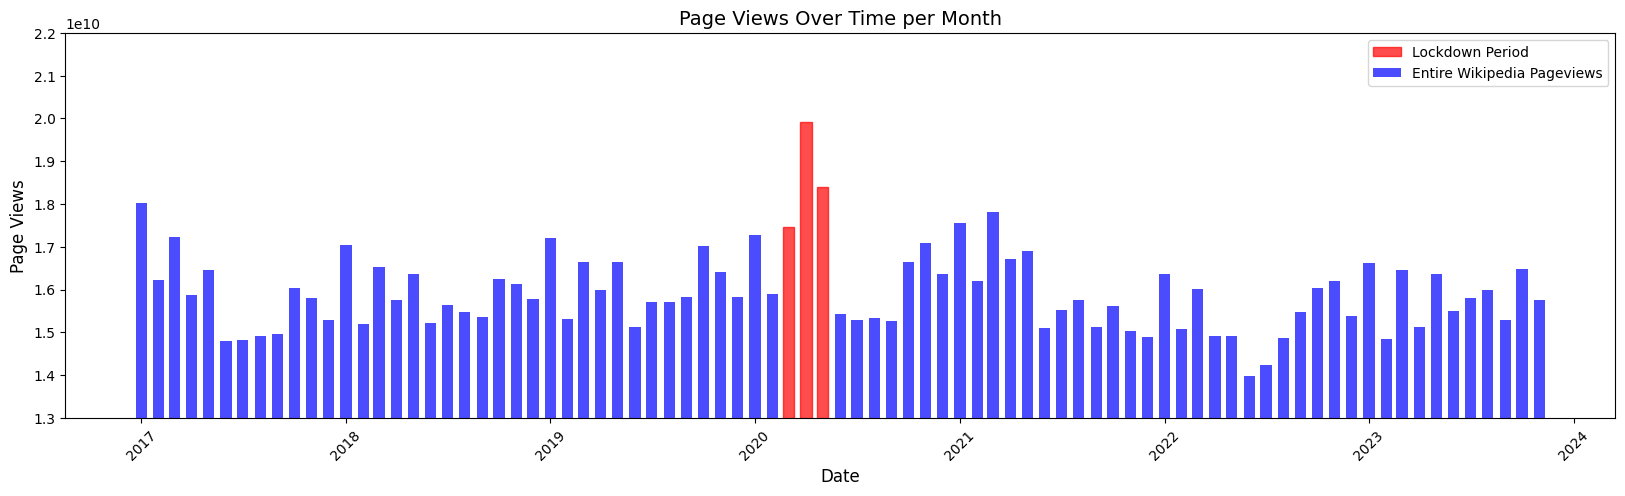

In [36]:
# Plot the total views on wikipedia to show the impact of lockdown
df_lang = df_interventions[df_interventions['lang'] == 'en']

# Extract the monthly overall views for the bar plot
df_wikiviews['Month'] = df_wikiviews.index.to_period('M')
monthly_data = df_wikiviews.groupby('Month')['all-projects'].sum()
df_wikiviews.drop(['Month'], axis=1)
monthly_data.index = monthly_data.index.to_timestamp()

fig, ax = plt.subplots(figsize=(20, 5))

bars = plt.bar(monthly_data.index[:-1], monthly_data[:-1], label='Entire Wikipedia Pageviews', color='blue', alpha=0.7, width=20)

# Change the color of lockdown months
for date in ['2020-03-01', '2020-04-01', '2020-05-01']:
    idx = np.where(monthly_data.index == pd.to_datetime(date))[0]
    idx = idx[0]
    bars[idx].set_color('red')

bars[idx].set_label('Lockdown Period')
plt.legend()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Page Views', fontsize=12)
plt.title('Page Views Over Time per Month', fontsize=14)
plt.ylim(1.3e10, 2.2*1e10)
plt.xticks(rotation=45)

plt.show()

This graph presents the montly pageview on Wikipedia. The period corresponding to the lockdown is highlighted in red. These months suggest a trend of higher pageviews during the lockdown. In order to determine whether this change is significant, we will do a statistical test.

Month: 2020-03-01
t-statistic: 1.8764381108485415
p-value: 0.06849961480493616
No significant change

Month: 2020-04-01
t-statistic: 5.044778202779336
p-value: 1.2282201379610492e-05
Significant change

Month: 2020-05-01
t-statistic: 3.092279136942405
p-value: 0.003766117226821406
Significant change



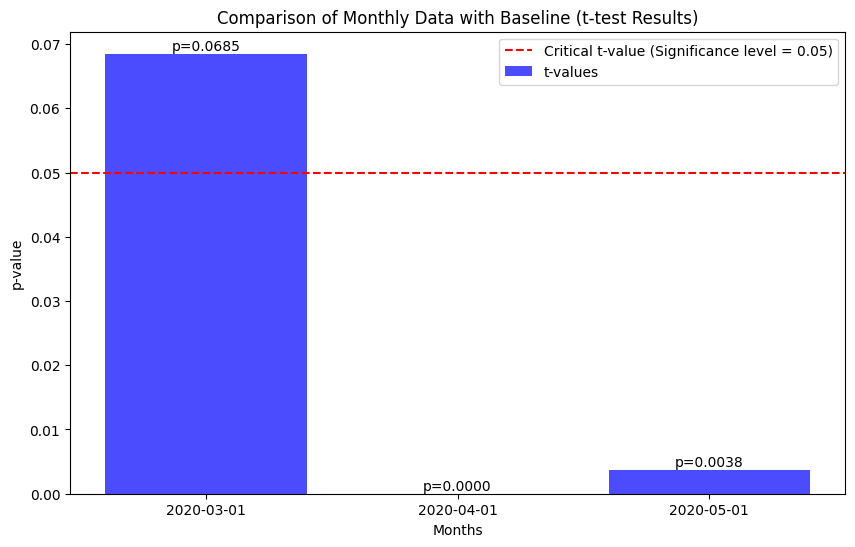

In [37]:
# Months to test for significant changes
target_months = ['2020-03-01', '2020-04-01', '2020-05-01']

# Baseline months (all before covid)
baseline_months = list(monthly_data.loc[:'2020-02-01'].index)

target_data = monthly_data[monthly_data.index.isin(target_months)]
baseline_data = monthly_data[monthly_data.index.isin(baseline_months)]

t_values, p_values = [], []

for month in target_months:
    target_views = target_data.loc[target_data.index == month]
    baseline_views = baseline_data

    t_stat, p_value = stats.ttest_ind(target_views, baseline_views)
    t_values.append(t_stat)
    p_values.append(p_value)
    print(f"Month: {month}")
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_value}")
    print("Significant change" if p_value < 0.05 else "No significant change")
    print()

# Bar Plot to show if the changes are significant for the months studied
significance_level = 0.05

plt.figure(figsize=(10, 6))

plt.bar(target_months, p_values, color='blue', alpha=0.7, label='t-values')
plt.axhline(y=significance_level, color='red', linestyle='--', label='Critical t-value (Significance level = 0.05)')

for i in range(len(target_months)):
    plt.text(target_months[i], p_values[i], f'p={p_values[i]:.4f}', ha='center', va='bottom')

plt.xlabel('Months')
plt.ylabel('p-value')
plt.title('Comparison of Monthly Data with Baseline (t-test Results)')
plt.legend()

plt.show()

The results of the statistical test support our hypothesis, which shows that there is a statistically significant change in pageviews in April and May 2020, with a significance level of 0.05.

### 2. Chess games

In [ ]:
df_chess = fetch_chess()
interactive_chess(df_chess, df_interventions)

In [13]:
list_chess = ["Chess", "Makruk", "Chaturanga", "Janggi", "Xiangqi", "Sittuyin", "Shogi"]

df_chess = pd.DataFrame()

for name in list_chess:
  # Retrieve page views for the entire wikipedia for a particular country:
  url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/{name}/daily/{start_dt}/{end_dt}"
  df_chess = pd.concat([df_chess, return_wiki_fetched(url)])

In [14]:
# Data Wrangling:
df_chess = df_chess[['project', 'article', 'timestamp','views']].reset_index(drop=True)
df_chess['timestamp'] = pd.to_datetime(df_chess['timestamp'], format='%Y%m%d%H')
df_chess['project'] = df_chess['project'].str.replace(r'\..*', '', regex=True)
df_chess = df_chess.pivot_table(index = 'timestamp', columns = ['article'], values = 'views')
df_chess.columns.set_names(['Game Name'], inplace=True)

In [15]:
# Take a look at our dataframe
df_chess.head()

Game Name,Chaturanga,Chess,Janggi,Makruk,Shogi,Sittuyin,Xiangqi
timestamp,,,,,,,
2017-01-01,312,5859,88,66,893,33,597
2017-01-02,410,6338,108,68,1047,40,643
2017-01-03,424,6049,117,70,1082,38,621
2017-01-04,392,6019,123,71,1023,38,712
2017-01-05,406,5915,123,65,1065,33,643


This function returns a matplotlib figure that will be called to update the interactive plots.

In [30]:
def return_figure(column_name, df, ax, title, language='en', weekends=False):

    # Extract intervention dates for specific languages
    df_lang = df_interventions[df_interventions['lang']==language]

    # Plot taking into acount that we can have a pd.Series as entry
    if isinstance(df, pd.Series):
      ax.plot(df.index, df, label=language)
    else:
      ax.plot(df.index, df[language], label=language)

    # Plots a span for the period of lockdown in red
    lockdown_start = df_lang['Mobility'].iloc[0]
    lockdown_end = df_lang['Normalcy'].iloc[0]
    ax.axvspan(lockdown_start, lockdown_end, color='red', alpha=0.3, label='Lockdown Period')

    # Plot grey areas on weekends
    if weekends:
        weekends = [d for d in df.index if d.weekday() in [5, 6]]  # 5 = Saturday, 6 = Sunday
        for start in weekends:
            # Check if the next day is also a weekend
            if start + pd.Timedelta(days=1) in weekends:
                end = start + pd.Timedelta(days=1)
                ax.axvspan(start, end, facecolor='gray', edgecolor=None, alpha=0.2)

    ax.set_yscale('log')
    ax.legend(loc='upper right', fontsize=9)
    ax.set_xlabel('Date')
    ax.set_ylabel('Views on the page (log scale)')
    ax.set_title(title)

    return ax

In [38]:
game_selector = widgets.Dropdown(
    options=list_chess,
    description="Select a Game:",
    disabled=False,
)

# Interactive plot to show selected game for english language
@interact(game_name=game_selector)
def update_plot(game_name):
    fig, ax = plt.subplots(figsize=(32, 10))
    ax = return_figure(game_name, df_chess[game_name], ax, f'Page Views Over Time for {game_name} in English', weekends=True)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    fig.autofmt_xdate(rotation=45)
    fig.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='Select a Game:', options=('Chess', 'Makruk', 'Chaturanga', 'Janggi…

The time series for the different types of chess games indicate a clear increase of pageviews during the pandemic, a period highlighted in red on the graph. The weekends, marked in grey, align with the various peaks within the series, showing an increase in interest. Additionally, a notable increaseis observed towards the end of 2020, however, this change is not covered by our study, given that chess experienced a significant surge in popularity independently of the increase in leisure time.

### 3. More popular Board Games

In [ ]:
df_boardgames, list_boardgames = fetch_boardgames()
interactive_boardgames(df_boardgames, list_boardgames, df_interventions)

In [22]:
# Name of the board games in English
list_boardgames_original = {
    "Catan",
    "Ticket to Ride (board game)",
    "Pandemic (board game)",
    "Carcassonne (board game)",
    "Risk (game)",
    "Monopoly (game)",
    "Scrabble",
    "Chess",
    "Backgammon",
    "Cluedo",
    "Twilight Struggle",
    "Agricola (board game)",
    "7 Wonders (board game)",
    "Terraforming Mars (board game)",
    "Dominion (card game)",
    "Power Grid",
    "Betrayal at House on the Hill",
    "Splendor (game)",
    "Gloomhaven",
    "Azul (board game)",
    "Chess"
}

In [ ]:
wiki_wiki = wikipediaapi.Wikipedia('ADABot/0.0 (floydchow7@gmail.com)', 'en')

In [23]:
# Use the API to find the name of the board Games in different languages
def print_langlinks(list_names):
    list_names_languages = {}
    for name_original in list_names:
        name = name_original.replace(' ', '_')
        page = wiki_wiki.page(name)
        langlinks = page.langlinks
        list_lang = {'en': name_original, 'fr': None, 'it': None, 'de': None, 'ja': None}
        for k in sorted(langlinks.keys()):
            v = langlinks[k]
            if v.language in list(list_lang.keys()):
                list_lang[v.language] = v.title
        # Save the names in a dictionnary to extract them later
        list_names_languages[name] = list_lang
    return list_names_languages

In [24]:
list_boardgames = print_langlinks(list_boardgames_original)

In [ ]:
df_boardgames_en = extract_bg_en(df_boardgames)
interactive_boardgames_lang(df_boardgames, df_interventions)
show_standardized_boardgames_en(df_interventions, df_boardgames_en)

In [28]:
df_boardgames = pd.DataFrame()

for name in list_boardgames:
    for language in country_code:
      name_lang = list_boardgames[name][language]
      if name_lang != None:
          # Retrieve page views for the entire wikipedia for a particular country:
          url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{language}.wikipedia/all-access/user/{name_lang}/daily/{start_dt}/{end_dt}"
          df_onequery = return_wiki_fetched(url)
          df_onequery['article'] = name
          df_boardgames = pd.concat([df_boardgames,df_onequery])

In [29]:
# Data wrangling:
df_boardgames = df_boardgames[['project', 'article', 'timestamp','views']].reset_index(drop=True)
df_boardgames['timestamp'] = pd.to_datetime(df_boardgames['timestamp'], format='%Y%m%d%H')
df_boardgames['project'] = df_boardgames['project'].str.replace(r'\..*', '', regex=True)
df_boardgames = df_boardgames.pivot_table(index = 'timestamp', columns = ['article', 'project'], values = 'views')
df_boardgames.columns.set_names(['Game Name', 'Language'], level=[0, 1], inplace=True)

In [ ]:
# Take a look at our dataframe
df_boardgames.head()

In [41]:
game_selector = widgets.Dropdown(
    options=list(list_boardgames.keys()),
    description="Select a Game:",
    disabled=False,
)

language_selector = widgets.Dropdown(
    options=country_code,
    description="Select a Language Option:",
    disabled=False,
)

# Interactive plot to show selected game for selected language
@interact(game_name=game_selector, language_name=language_selector)
def update_plot(game_name, language_name):
    clear_output(wait=True)  # Clear previous output
    fig, ax = plt.subplots(figsize=(32, 10))
    try:
        ax = return_figure(game_name, df_boardgames[game_name], ax, f'Page Views Over Time for {game_name}', language_name)
        ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        fig.autofmt_xdate(rotation=45)  # Rotates the x-axis labels for better readability
        fig.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
        plt.show()
    except:
       print('The pageviews is not disponible for this game in this language, please choose another combination.')

interactive(children=(Dropdown(description='Select a Game:', options=('Azul_(board_game)', 'Risk_(game)', 'Tic…

This time serie is similar to the one we had before, here again the pandemic times are highlighted in red. These games are less subject to significant surge in interest in the recent years. This is why they are suited for our study. The shift in interest during the pandemic provides a basis for our analysis.

### 4. Study of the evolution of interest in board games.

In [ ]:
model = train_evaluate_LSTM_model(pre_process_data(df_boardgames_en))
test_model(df_boardgames_en, df_interventions, model)

In [42]:
# Extract the pageviews for boardgames in English language
df_boardgames_en = pd.DataFrame()

for column in df_boardgames.columns:
    if column[1] == 'en':
        df_boardgames_en[column[0]] = df_boardgames[column]

In [56]:
def return_fig_boardgames_lang(fig, ax1, language):

    # Extract the data of a particular board game
    df = pd.DataFrame()
    for column in df_boardgames.columns:
        if column[1] == language:
            df[column[0]] = df_boardgames[column]

    ax1.plot(df.index, df.sum(axis=1).rolling(window=7).mean(), label = 'Interest for Board Games', alpha=0.7, color = 'blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Y-axis (Board Games Views)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Create a second y-axis on the right
    ax2 = ax1.twinx()

    ax2.plot(df_wikiviews.index, df_wikiviews[language].rolling(window=7).mean(), label = f'Interest for Wikipedia {language}', color = 'red', alpha=0.8)
    ax2.set_ylabel(f'Y-axis ({language} Wikipedia Views)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Adds a red span conresponding to the lockdown period
    df_lang = df_interventions[df_interventions['lang']==language]
    lockdown_start = df_lang['Mobility'].iloc[0]
    lockdown_end = df_lang['Normalcy'].iloc[0]
    plt.axvspan(lockdown_start, lockdown_end, color='red', alpha=0.3, label='Lockdown Period')

    plt.title(f'Pageviews for Board Games and Wikipedia for {language} (smoothened)')

    return fig

In [53]:
language_selector = widgets.Dropdown(
    options=country_code,
    description="Select a Language Option:",
    disabled=False,
)

# Creates interactive plot and changes it given the language
@interact(language=language_selector)
def update_plot(language):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(16, 5))
    fig = return_fig_boardgames_lang(fig, ax, language)
    fig.autofmt_xdate(rotation=45)
    fig.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='Select a Language Option:', options=('en', 'fr', 'it', 'de', 'ja')…

This time series, showing Wikipedia pageviews in general and board game pageviews in particular, reveals some interesting trends: at the end of the year, a general decline in Wikipedia pageviews is evident, while interest in board games increases at the same time. It is interesting to note that this is the first time that Wikipedia as a whole and board games in particular have both had increases in pageviews at the same time. With this is mind, we will create a predictive model to determine whether the previous patterns of these two different trends can be used to predict this transition.

In [57]:
scaler_standardization = StandardScaler()

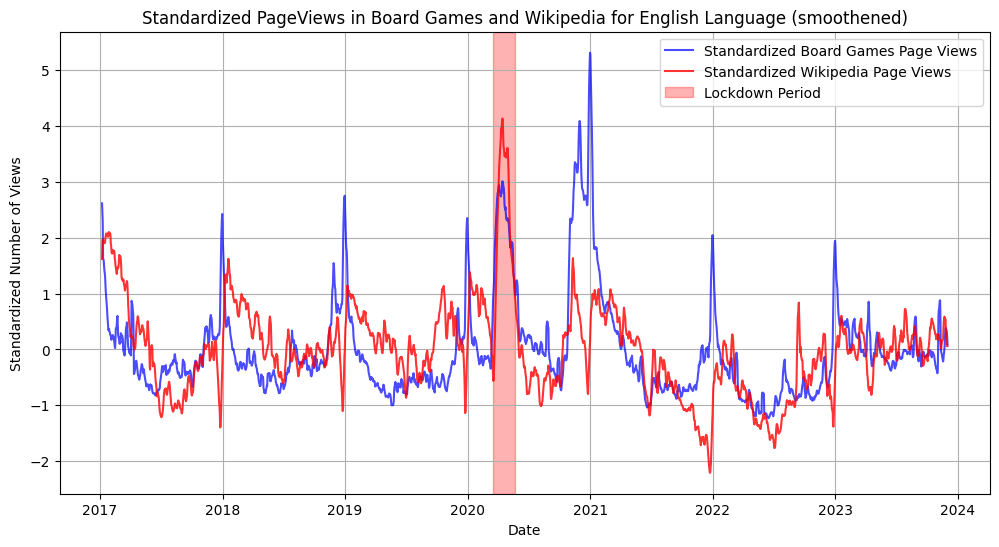

In [58]:
# Extracting language dates for English
df_lang = df_interventions[df_interventions['lang']=='en']

lockdown_start = df_lang['Mobility'].iloc[0]
lockdown_end = df_lang['Normalcy'].iloc[0]

# Standardization of input data and actual data to compare the results
stand_wiki = scaler_standardization.fit_transform(df_wikiviews[['en']])
temp = pd.DataFrame({'temp': df_boardgames_en.sum(axis=1)})
stand_boardgames = scaler_standardization.fit_transform(temp[['temp']])

# Smoothened data to ease the reading
df_data = pd.DataFrame({'wiki': stand_wiki[:, 0], 'board': stand_boardgames[:, 0]})
window_size = 7
smoothed_data1 = df_data['wiki'].rolling(window=window_size).mean()
smoothed_data2 = df_data['board'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_boardgames_en.index, smoothed_data2, label = 'Standardized Board Games Page Views', alpha=0.7, color = 'blue')
plt.plot(df_wikiviews.index, smoothed_data1, label = 'Standardized Wikipedia Page Views', color = 'red', alpha=0.8)
plt.axvspan(lockdown_start, lockdown_end, color='red', alpha=0.3, label='Lockdown Period')
plt.xlabel('Date')
plt.ylabel('Standardized Number of Views')
plt.title('Standardized PageViews in Board Games and Wikipedia for English Language (smoothened)')
plt.legend()
plt.grid()
plt.show()

On this plot, we observe that standardized pageviews have the same trends as the ones identified in the previous plot. We will use this standardized data to train our predictive model to improve convergence and numerical stability.

In [70]:
# Data pre processing for the model:

data = pd.DataFrame({'interest': df_boardgames_en.sum(axis=1)})
# Data to train the model taken before 2020 to properly show the influence of the pandemic
data = data[(data.index <= pd.to_datetime(datetime(2020,1,1)))]

data['interest_wikipedia'] = df_wikiviews['en']

data = data.dropna()

# Standardization to better the meaningfulness of the results
scaler_standardization = StandardScaler()
data['interest'] = scaler_standardization.fit_transform(data[['interest']])
data['interest_wikipedia'] = scaler_standardization.fit_transform(data[['interest_wikipedia']])

# Defining feature and target variables
X = data['interest_wikipedia']
y = data['interest']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Creating sequences of 20 days to use for the prediction
sequences = []

for i in range(10, len(X)-9):
    sequences.append([X[i-10], X[i-9], X[i-8], X[i-7], X[i-6], X[i-5], X[i-4],
                      X[i-3], X[i-2], X[i-1], X[i], X[i+1], X[i+2], X[i+3],
                      X[i+4], X[i+5], X[i+6], X[i+7], X[i+8], X[i+9]])

sequence_length = len(sequences[0])
feature_dim = len(sequences[0])

# Creating a tensor for the input data (sequences)
input_tensor = torch.zeros(len(sequences), sequence_length, feature_dim, dtype=torch.float32)

for i, sequence in enumerate(sequences):
    input_tensor[i, :, :] = torch.tensor(sequence, dtype=torch.float32)

In [71]:
# Defining the LSTM-based neural network model
class LSTMRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMRegression, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        out = self.fc(lstm_out[:, -1, :])
        return out

# Defining the model's hyperparameters
input_dim = input_tensor.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1

# Initializing the model
model = LSTMRegression(input_dim, hidden_dim, num_layers, output_dim)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Splitting the data
X_train_seq, X_test_seq, y_train, y_test = train_test_split(input_tensor, y[10:-9], test_size=0.5, random_state=42)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Training of the model
epochs = 50
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_seq)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Make predictions on the test set
with torch.no_grad():
    y_pred_tensor = model(X_test_seq).numpy()

y_pred = y_pred_tensor.flatten()

Mean Squared Error (MSE): 0.47
R-squared (R2): 0.40


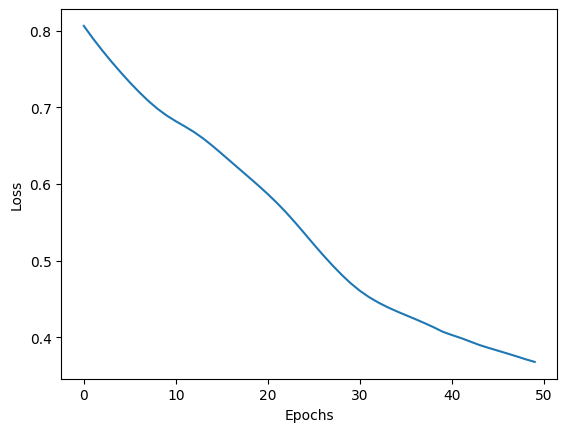

In [72]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

The plot illustrates the model's loss given the epoch, showing the learning process over time. With an R-squared value of 0.4, the model demonstrates a moderate level of accuracy in explaining the variance in the dataset. Rhe model provides a foundational basis for predicting changes in pageviews during the lockdown period.

In [76]:
# Standardizing the pageviews of English Wikipedia of Board Games
normalized = scaler_standardization.fit_transform(df_boardgames_en.sum(axis=1).values.reshape(-1, 1))
normalized = normalized[:, 0]

# Standardizing the pageviews of English Wikipedia to predict the behavior of Board Games Pageviews
normalized_wiki = scaler_standardization.fit_transform(df_wikiviews['en'].values.reshape(-1, 1))
normalized_wiki = normalized_wiki[:, 0]

new_data = []

for i in range(10, len(normalized_wiki)-9):
    new_data.append([normalized_wiki[i-10], normalized_wiki[i-9], normalized_wiki[i-8], normalized_wiki[i-7], normalized_wiki[i-6], normalized_wiki[i-5], normalized_wiki[i-4],
                     normalized_wiki[i-3], normalized_wiki[i-2], normalized_wiki[i-1], normalized_wiki[i], normalized_wiki[i+1], normalized_wiki[i+2], normalized_wiki[i+3],
                     normalized_wiki[i+4], normalized_wiki[i+5], normalized_wiki[i+6], normalized_wiki[i+7], normalized_wiki[i+8], normalized_wiki[i+9]])

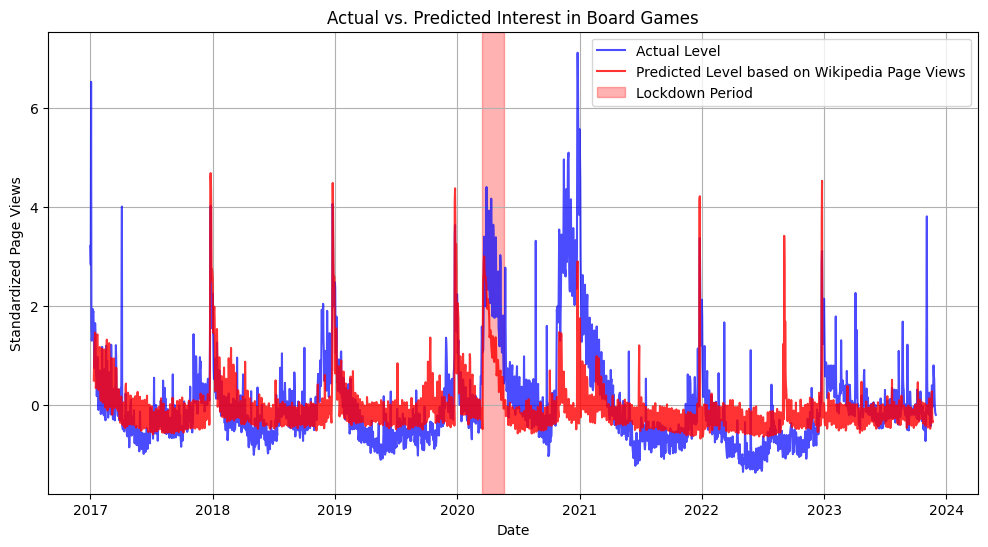

In [77]:
# Create an empty tensor to hold the input data
sequence_length = len(new_data[0])
feature_dim = len(new_data[0])
input_tensor = torch.zeros(len(new_data), sequence_length, feature_dim, dtype=torch.float32)

for i, new_data in enumerate(new_data):
    input_tensor[i, :, :] = torch.tensor(new_data, dtype=torch.float32)

# Predicting the standardized Board Games Pageviews
with torch.no_grad():
    predicted = model(input_tensor).numpy()
predicted = predicted.flatten()

plt.figure(figsize=(12, 6))
plt.plot(df_boardgames_en.index, normalized, label = 'Actual Level', alpha=0.7, color = 'blue')
plt.plot(df_boardgames_en.index[10:-9], predicted, label = 'Predicted Level based on Wikipedia Page Views', color = 'red', alpha=0.8)
plt.axvspan(lockdown_start, lockdown_end, color='red', alpha=0.3, label='Lockdown Period')
plt.xlabel('Date')
plt.ylabel('Standardized Page Views')
plt.title('Actual vs. Predicted Interest in Board Games')
plt.legend()
plt.grid()
plt.show()

This first plot, comparing the predicted and actual values of the standardized number of pageviews, reveals a nsignificant difference around the end of 2021 and during the lockdown. These differences highlight a change in people's attitudes toward board games during these times. The observed differences can probably be attributed to the COVID-19 pandemic's effects. Furthermore, the unanticipated rise that was seen near the end of 2021 can be explained by the increase in quality time spent with relatives after a year and a half of pandemic. This trend suggests that external societal factors, such as the pandemic, significantly influenced and potentially altered the predictive modeling outcomes.

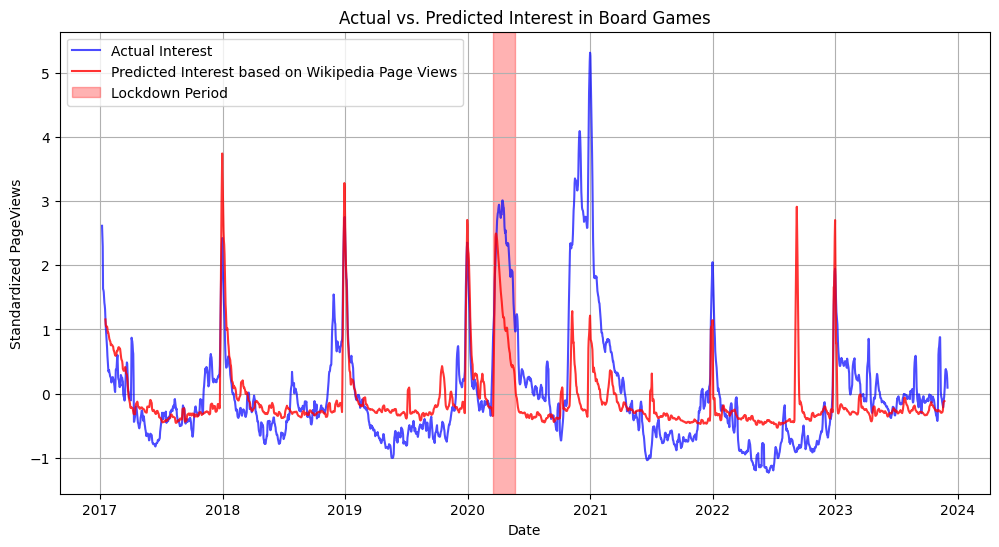

In [66]:
# Smoothening the plot for a window of a week
df1 = pd.DataFrame({'pred': predicted})
df2 = pd.DataFrame({'actual': normalized})

window_size = 7
smoothed_data1 = df1['pred'].rolling(window=window_size).mean()
smoothed_data2 = df2['actual'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_boardgames_en.index, smoothed_data2, label = 'Actual Interest', alpha=0.7, color = 'blue')
plt.plot(df_boardgames_en.index[10:-9], smoothed_data1, label = 'Predicted Interest based on Wikipedia Page Views', color = 'red', alpha=0.8)
plt.axvspan(lockdown_start, lockdown_end, color='red', alpha=0.3, label='Lockdown Period')
plt.xlabel('Date')
plt.ylabel('Standardized PageViews')
plt.title('Actual vs. Predicted Interest in Board Games')
plt.legend()
plt.grid()
plt.show()

Here is a plot of the same data but smoothened on a weekly basis to improve readability.